In [30]:
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
%matplotlib inline


In [41]:
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
ticks = ['XLB','XLI','XLY','XLP', 'XLE','XLF','XLU','XLV','XLK']
end = date.today()
beg = (end - relativedelta(years = 10)).strftime("%Y-%m-%d")
end = end.strftime("%Y-%m-%d")
data = pd.DataFrame()
for sym in ticks:
    data[sym] = yf.download(sym, start=beg, end=end)['Adj Close']

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [91]:
#lets calc returns and cov matrix
rets = np.log(1+data.pct_change())
mean_rets = rets.mean()*252
cov = rets.cov()*252
syms = len(ticks)

In [178]:
##now we simulate the returns of the portfolio across random samples
prets = []
pvols = []

for trial in range(20000):
    weights = np.random.random(syms)
    weights /= np.sum(weights)
    prets.append(np.sum(mean_rets*weights))
    pvols.append(np.sqrt(np.dot(weights.T,
                                np.dot(cov,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

In [140]:
#function for computing portfolio returns, std, and shapre
def port_stats(weights):
    w = np.array(weights)
    r = np.sum(w*mean_rets)
    std = np.sqrt(np.dot(w.T,np.dot(cov,w)))
    sharpe = r/std
    return np.array([r,std,sharpe])

In [168]:
import scipy.optimize as sco
#boundaries
bnds = tuple((0,.3) for x in range(syms))
#constraints
cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})

#returns negative of sharpe b/c minimum of negative sharpe is the maximum of the sharpe ratio
def max_sharpe(weights):
    return -port_stats(weights)[2]

guess = syms*[1/syms]
sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)

#now lets find the min variance portfolio

def min_var(weights):
    return port_stats(weights)[1]

min_var_opt = sco.minimize(min_var, guess, method = 'SLSQP',constraints=cons, bounds=bnds)


In [176]:
#now lets create an efficient frontier for this dataset
frets = np.linspace(0.06, .13, 50)
fvols = []
for ret in frets:
    cons = ({'type':'eq', 'fun':lambda x: port_stats(x)[0]-ret},
            {'type':'eq','fun':lambda x: np.sum(x)-1})
    res = sco.minimize(min_var, guess, constraints = cons, bounds = bnds, method ='SLSQP')
    fvols.append(res['fun']) ## this is the actual vol
fvols = np.array(fvols)

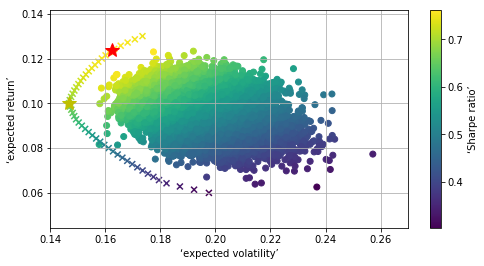

In [179]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(fvols, frets,
c=frets / fvols, marker='x')
# efficient frontier
plt.plot(port_stats(sharpe_opt['x'])[1], port_stats(sharpe_opt['x'])[0],
'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(port_stats(min_var_opt['x'])[1], port_stats(min_var_opt['x'])[0],
'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('‘expected volatility’')
plt.ylabel('‘expected return’')
plt.colorbar(label='‘Sharpe ratio’')

In [213]:
import scipy.interpolate as sci
##this code starts the interpolation at the minvar Portfolion
ind = np.argmin(fvols)
evols = fvols[ind:]
erets = frets[ind:]
tck = sci.splrep(evols, erets)

In [214]:
#define function
def f(x):
    return sci.splev(x,tck,der=0)
def df(x):
    return sci.splev(x,tck,der=1)

def CAPM_eq(p,rf=0.0175):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2]-f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1,eq2,eq3

#solivng the CAPM equation
CAPM_opt = sco.fsolve(CAPM_eq,[.0175,.5,.15])
CAPM_opt

array([0.0175    , 0.65404909, 0.16367907])

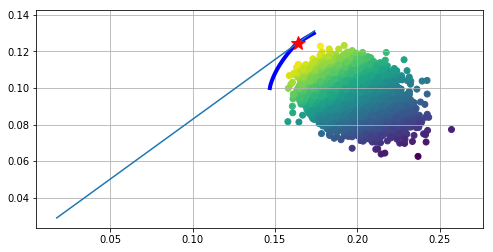

In [215]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'b', lw=4.0)
rang = np.linspace(.0175,.174)
plt.plot(rang, CAPM_opt[0] + CAPM_opt[1]*rang)
plt.plot(CAPM_opt[2], f(CAPM_opt[2]), 'r*', markersize=15.0)
plt.grid(True)

In [216]:
evols.max()

0.17356602257427742